# Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# hrlo

# Necessary Imports

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.amp import autocast, GradScaler
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Import Training, Testing and Validation Data

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Dataset/train.csv')
val_df = pd.read_csv('/content/drive/MyDrive/Dataset/validation.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Dataset/test.csv')

In [4]:
df.head()

,question,sql
0,Tell me what the notes are for South Australia,SELECT Notes FROM table WHERE Current slogan =...
1,What is the current series where the new serie...,SELECT Current series FROM table WHERE Notes =...
2,What is the format for South Australia?,SELECT Format FROM table WHERE State/territory...
3,Name the background colour for the Australian ...,SELECT Text/background colour FROM table WHERE...
4,how many times is the fuel propulsion is cng?,SELECT COUNT Fleet Series (Quantity) FROM tabl...


In [5]:
len(df)

56355

In [ ]:
df = df.sample(n=25000)

In [ ]:
len(df)

In [7]:
questions = df['question'].tolist()
sql_queries = df['sql'].tolist()

# Importing Tokenizer and pretrained t5-base

In [8]:
tokenizer = T5Tokenizer.from_pretrained('t5-base')
tokenized_inputs = tokenizer.batch_encode_plus(questions, padding=True, truncation=True, return_tensors='pt')
tokenized_outputs = tokenizer.batch_encode_plus(sql_queries, padding=True, truncation=True, return_tensors='pt')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


# Data loader using TensorDataset

In [9]:
# Assume tokenized_inputs and tokenized_outputs are dictionaries containing PyTorch tensors
input_ids = tokenized_inputs['input_ids'].clone().detach()
attention_mask = tokenized_inputs['attention_mask'].clone().detach()
labels = tokenized_outputs['input_ids'].clone().detach()
decoder_attention_mask = tokenized_outputs['attention_mask'].clone().detach()

In [10]:
train_dataset = TensorDataset(input_ids, attention_mask, labels, decoder_attention_mask)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)

# Data loader using custom dataset loader

In [ ]:
class SQLDatasetLoad(Dataset):
    def __init__(self, tokenized_inputs, tokenized_outputs):
        self.input_ids = tokenized_inputs['input_ids']
        self.attention_mask = tokenized_inputs['attention_mask']
        self.labels = tokenized_outputs['input_ids']
        self.decoder_attention_mask = tokenized_outputs['attention_mask']

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': self.labels[idx],
            'decoder_attention_mask': self.decoder_attention_mask[idx]
        }


In [ ]:
train_datasetC = SQLDatasetLoad(tokenized_inputs, tokenized_outputs)
train_loaderC = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)

# Model(s) initialization and training

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

K-Fold Cross-Validation

In [ ]:
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

fold_losses = []

for fold, (train_index, val_index) in enumerate(kf.split(df)):
    print(f"Fold {fold + 1}/{num_folds}")

    # Split data into training and validation sets for the current fold
    train_df = df.iloc[train_index]
    val_df = df.iloc[val_index]

    # Tokenize and prepare DataLoader for training
    questions_temp = train_df['question'].tolist()
    sql_queries_temp = train_df['sql'].tolist()

    tokenizer = T5Tokenizer.from_pretrained('t5-base')
    tokenized_inputs_temp = tokenizer.batch_encode_plus(questions_temp, padding=True, truncation=True, return_tensors='pt')
    tokenized_outputs_temp = tokenizer.batch_encode_plus(sql_queries_temp, padding=True, truncation=True, return_tensors='pt')

    input_ids_temp = tokenized_inputs_temp['input_ids']
    attention_mask_temp = tokenized_inputs_temp['attention_mask']
    labels_temp = tokenized_outputs_temp['input_ids']

    train_dataset = TensorDataset(input_ids_temp, attention_mask_temp, labels_temp)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)

    # Initialize model, optimizer, and GradScaler
    model = T5ForConditionalGeneration.from_pretrained('t5-base').to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)
    scaler = GradScaler('cuda')

    # Training loop for the current fold
    train_losses = []
    for epoch in range(4):
        model.train()
        running_loss = 0.0
        for batch in train_loader:
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)

            optimizer.zero_grad()

            with autocast('cuda'):
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        #print(f'Epoch: {epoch + 1}, Loss: {epoch_loss}')

    #Prepare DataLoader for validation
    val_questions = val_df['question'].tolist()
    val_sql_queries = val_df['sql'].tolist()

    tokenized_inputs_val = tokenizer.batch_encode_plus(val_questions, padding=True, truncation=True, return_tensors='pt')
    tokenized_outputs_val = tokenizer.batch_encode_plus(val_sql_queries, padding=True, truncation=True, return_tensors='pt')

    input_ids_val = tokenized_inputs_val['input_ids']
    attention_mask_val = tokenized_inputs_val['attention_mask']
    labels_val = tokenized_outputs_val['input_ids']

    val_dataset = TensorDataset(input_ids_val, attention_mask_val, labels_val)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

    #Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            inputs = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)

            with autocast('cuda'):
                outputs = model(input_ids=inputs, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
            val_loss += loss.item()

    val_loss /= len(val_loader)
    fold_losses.append(val_loss)
    print(f"Validation Loss for Fold {fold + 1}: {val_loss}")

    #Free up memory
    del model, optimizer, scaler
    torch.cuda.empty_cache()

#Performance metrics across all folds
average_loss = sum(fold_losses) / len(fold_losses)
print(f"Average Loss across all folds: {average_loss}")

Fold 1/5


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Epoch: 1, Loss: 0.7286742508649826
Epoch: 2, Loss: 0.14751545898914337
Epoch: 3, Loss: 0.12106365152597427
Epoch: 4, Loss: 0.1062877659201622
Epoch: 5, Loss: 0.09642459505200386
Epoch: 6, Loss: 0.08879496073126793
Epoch: 7, Loss: 0.08210049983859062
Epoch: 8, Loss: 0.07674690837860107
Epoch: 9, Loss: 0.07187146902680397
Epoch: 10, Loss: 0.06808438626527787
Validation Loss for Fold 1: 0.09450570505800521
Fold 2/5


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Epoch: 1, Loss: 0.7452562918663025
Epoch: 2, Loss: nan
Epoch: 3, Loss: 0.12187490553855895
Epoch: 4, Loss: 0.10763266329169273
Epoch: 5, Loss: 0.09736892080903053
Epoch: 6, Loss: 0.08931226651668549
Epoch: 7, Loss: 0.08269835671186447
Epoch: 8, Loss: 0.07751295652389527
Epoch: 9, Loss: 0.07258483751416206
Epoch: 10, Loss: 0.06821111644506454
Validation Loss for Fold 2: 0.08383975135292976
Fold 3/5


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
#Plot the validation loss per fold
plt.plot(range(1, num_folds + 1), fold_losses)
plt.title('Fold-wise Validation Loss')
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.show()

Final Training of model across entire dataset

In [ ]:
model = T5ForConditionalGeneration.from_pretrained('t5-base').to(device)

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)

In [ ]:
scaler = GradScaler('cuda')
training_losses = []

for epoch in range(10):
    running_loss = 0.0
    for batch in train_loader:
        input_ids, attention_mask, labels, decoder_attention_mask = [b.to(device) for b in batch]

        optimizer.zero_grad()

        with autocast('cuda'):
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels,
                decoder_attention_mask=decoder_attention_mask,
                return_dict=True
            )
            loss = outputs.loss

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    training_losses.append(epoch_loss)

    print(f'Epoch: {epoch + 1}, Loss: {epoch_loss}')

In [ ]:
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### model2 for training on data loaded with custom data loader

In [ ]:
model2 = T5ForConditionalGeneration.from_pretrained('t5-base').to(device)

In [ ]:
optimizer2 = torch.optim.AdamW(model2.parameters(), lr=3e-5)

In [ ]:
train_losses2 = []
for epoch in range(10):
    running_loss = 0.0  # Reset running_loss for each epoch
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        decoder_attention_mask = batch['decoder_attention_mask'].to(device)
        optimizer2.zero_grad()
        outputs = model2(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels,
            decoder_attention_mask=decoder_attention_mask,
            return_dict=True
        )
        loss = outputs.loss
        loss.backward()
        optimizer2.step()
        running_loss += loss.item()  # Accumulate loss for the epoch

    epoch_loss = running_loss / len(train_loader)  # Calculate average epoch loss
    train_losses2.append(epoch_loss)

    print(f'Epoch: {epoch + 1}, Loss: {epoch_loss}')  # Print average epoch loss

In [ ]:
plt.plot(train_losses2)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Saving model

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/model3/sql2_model25ka.pt')

In [ ]:
torch.save(model2.state_dict(), '/content/drive/MyDrive/model3/sql2_model25kb.pt')

# Loading saved models

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
model3 = T5ForConditionalGeneration.from_pretrained('t5-base').to(device)
model4 = T5ForConditionalGeneration.from_pretrained('t5-base').to(device)

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/model3/sql_model5k.pt'))
model.eval()

In [ ]:
model2.load_state_dict(torch.load('/content/drive/MyDrive/model3/sql_model15k.pt', map_location=torch.device('cpu')))
model2.eval()

In [14]:
model3.load_state_dict(torch.load('/content/drive/MyDrive/model3/sql_model25k.pt'))
model3.eval()

<ipython-input-14-df94e2bbafb2>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model3.load_state_dict(torch.load('/content/drive/MyDrive/model3/sql_model25k.pt'))


T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [ ]:
model4.load_state_dict(torch.load('/content/drive/MyDrive/model3/sql2_model32ka.pt'))
model4.eval()

<ipython-input-9-f9935a26d79d>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model4.load_state_dict(torch.load('/content/drive/MyDrive/model3/sql2_model32ka.pt'))


T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [ ]:
tokenizer = T5Tokenizer.from_pretrained('t5-base')

# Saving Model's Prediction data

In [15]:
valX = val_df['question'].tolist()
valy = val_df['sql'].tolist()

In [16]:
valX[0]

'What position does the player who played for butler cc (ks) play?'

In [17]:
valy[0]

'SELECT Position FROM table WHERE School/Club Team = Butler CC (KS)'

In [ ]:
references1 = []
candidates1 = []
for i in range(len(val_df)):
  input_ids = tokenizer.encode(valX[i], return_tensors='pt').to(model.device)
  outputs = model.generate(input_ids=input_ids, max_length=100, num_beams=5, early_stopping=True)
  sql_query = tokenizer.decode(outputs[0], skip_special_tokens=True)
  references1.append(sql_query.split())
  candidates1.append(valy[i].split())

KeyboardInterrupt: 

In [ ]:
df1 = pd.DataFrame({'output': references1, 'actual': candidates1})
df1.to_csv('/content/drive/MyDrive/model3/5k_val.csv')

In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/model3/5k_val.csv')

In [ ]:
len(df1)

4584

In [ ]:
references2 = []
candidates2 = []
for i in range(len(df1)):
  input_ids = tokenizer.encode(valX[i], return_tensors='pt').to(model2.device)
  outputs = model2.generate(input_ids=input_ids, max_length=100, num_beams=5, early_stopping=True)
  sql_query = tokenizer.decode(outputs[0], skip_special_tokens=True)
  references2.append(sql_query.split())
  candidates2.append(valy[i].split())

In [ ]:
df2 = pd.DataFrame({'output': references2, 'actual': candidates2})
df2.to_csv('/content/drive/MyDrive/model3/15k_val.csv')

In [ ]:
df2 = pd.read_csv('/content/drive/MyDrive/model3/15k_val.csv')

In [ ]:
len(df2)

4584

In [ ]:
count = 0
score1 = 0
score2 = 0
for i in range(min(len(references2), len(references1))):
  score1 = score1 + sentence_bleu([references1[i]], candidates1[i], weights=(0.25, 0.25, 0.25, 0.25))
  score2 = score2 + sentence_bleu([references2[i]], candidates2[i], weights=(0.25, 0.25, 0.25, 0.25))
  count = count + 1

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

In [19]:
df3 = pd.read_csv('/content/drive/MyDrive/model3/25k_val.csv')

# Model Evaluation

In [26]:
vectorizer = TfidfVectorizer()
all_text = pd.concat([df3['output'], df3['actual']]).astype(str)
vectorizer.fit(all_text)
output_vectors = vectorizer.transform(df3['output'].astype(str))
actual_vectors = vectorizer.transform(df3['actual'].astype(str))

In [27]:
similarity_scores = cosine_similarity(output_vectors, actual_vectors)

In [25]:
similarity_scores

array([[0.91353773, 0.09617393, 0.08740435, ..., 0.05004589, 0.13307891,
        0.05434979],
       [0.39290652, 0.79718242, 0.63500934, ..., 0.08360679, 0.22232196,
        0.09079691],
       [0.34724297, 0.82179808, 1.        , ..., 0.07389002, 0.19648373,
        0.0802445 ],
       ...,
       [0.0458541 , 0.08154425, 0.07410867, ..., 0.90355133, 0.11283535,
        0.33684755],
       [0.1215726 , 0.21619762, 0.19648373, ..., 0.37606175, 1.        ,
        0.12217756],
       [0.04965059, 0.08829571, 0.0802445 , ..., 0.33585369, 0.12217756,
        1.        ]])

In [ ]:
count

4584

In [ ]:
avg1 = score1/count
avg2 = score2/count

In [ ]:
print(f"Average BLEU Score for model trained on 5k rows: {avg1}")
print(f"Average BLEU Score for model trained on 15k rows: {avg2}")

Average BLEU Score for model trained on 5k rows: 0.5489884439092326
Average BLEU Score for model trained on 15k rows: 0.6225858917676619


In [ ]:
!pip install rouge-score==0.1.2

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=97a485bd2268298ba20f375a795f549d66ea393593f74a90e5902c05f1f2d255
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [ ]:
from rouge_score import rouge_scorer

In [ ]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

In [ ]:
R_score1 = 0
R_score2 = 0
c = 0
for i in range(min(len(df1), len(df2))):
    R_score1 = R_score1 + scorer.score(df1.at[i,'output'], df1.at[i,'actual'])['rouge1'].fmeasure
    R_score2 = R_score2 + scorer.score(df2.at[i,'output'], df2.at[i,'actual'])['rouge1'].fmeasure
    c = c + 1

In [ ]:
avgR1 = R_score1/c
avgR2 = R_score2/c

In [ ]:
print(f"Average ROUGE Score for model trained on 5k rows: {avgR1}")
print(f"Average ROUGE Score for model trained on 15k rows: {avgR2}")

Average ROUGE Score for model trained on 5k rows: 0.8919598094826047
Average ROUGE Score for model trained on 15k rows: 0.9148973658247792


In [ ]:
R_score1 = 0
R_score2 = 0
c = 0
for i in range(min(len(df1), len(df2))):
    R_score1 = R_score1 + scorer.score(df1.at[i,'output'], df1.at[i,'actual'])['rouge2'].fmeasure
    R_score2 = R_score2 + scorer.score(df2.at[i,'output'], df2.at[i,'actual'])['rouge2'].fmeasure
    c = c + 1

In [ ]:
avgR1 = R_score1/c
avgR2 = R_score2/c

In [ ]:
print(f"Average ROUGE Score for model trained on 5k rows: {avgR1}")
print(f"Average ROUGE Score for model trained on 15k rows: {avgR2}")

Average ROUGE Score for model trained on 5k rows: 0.7612825174701917
Average ROUGE Score for model trained on 15k rows: 0.8046904808293588


In [ ]:
R_score1 = 0
R_score2 = 0
c = 0
for i in range(min(len(df1), len(df2))):
    R_score1 = R_score1 + scorer.score(df1.at[i,'output'], df1.at[i,'actual'])['rougeL'].recall
    R_score2 = R_score2 + scorer.score(df2.at[i,'output'], df2.at[i,'actual'])['rougeL'].recall
    c = c + 1

In [ ]:
avgR1 = R_score1/c
avgR2 = R_score2/c

In [ ]:
print(f"Average ROUGE Score for model trained on 5k rows: {avgR1}")
print(f"Average ROUGE Score for model trained on 15k rows: {avgR2}")

Average ROUGE Score for model trained on 5k rows: 0.8876087522334482
Average ROUGE Score for model trained on 15k rows: 0.9099675450416715


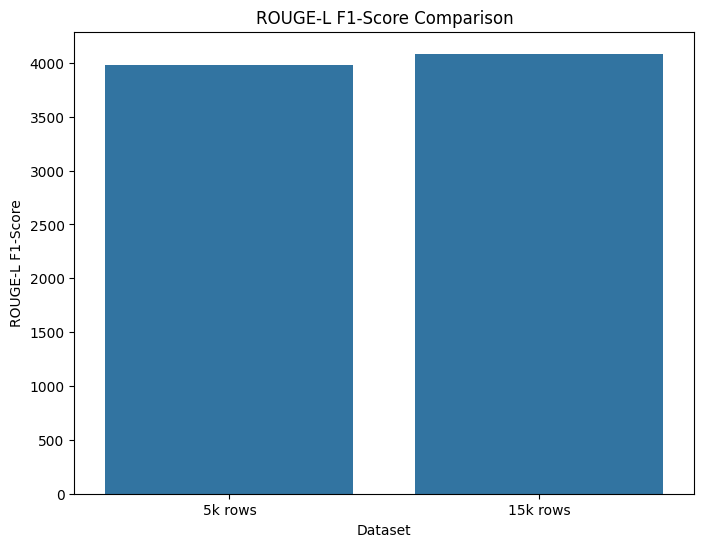

In [ ]:
rouge_scores = [R_score1, R_score2]
datasets = ['5k rows', '15k rows']  # Labels for the datasets

# Create a bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=datasets, y=rouge_scores)
plt.title('ROUGE-L F1-Score Comparison')  # Adjust title as needed
plt.ylabel('ROUGE-L F1-Score')
plt.xlabel('Dataset')
plt.show()

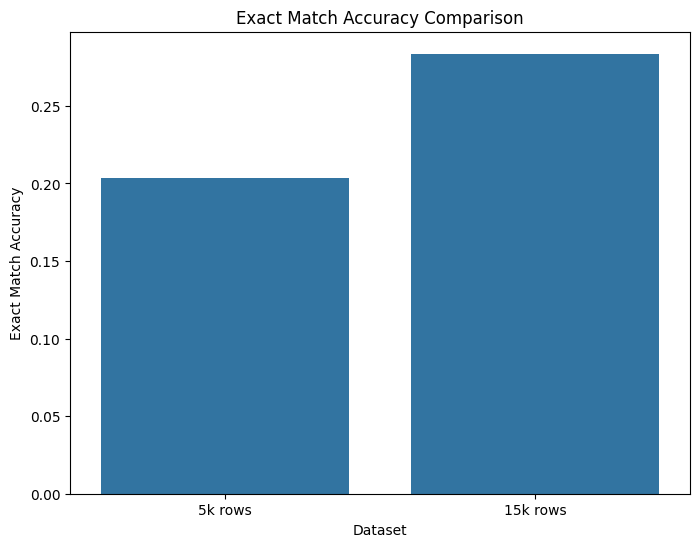

In [ ]:
exact_match_df1 = sum(df1['output'] == df1['actual']) / len(df1)
exact_match_df2 = sum(df2['output'] == df2['actual']) / len(df2)
exact_match_accuracies = [exact_match_df1, exact_match_df2]
datasets = ['5k rows', '15k rows']

plt.figure(figsize=(8, 6))
sns.barplot(x=datasets, y=exact_match_accuracies)
plt.title('Exact Match Accuracy Comparison')
plt.ylabel('Exact Match Accuracy')
plt.xlabel('Dataset')
plt.show()

In [ ]:
print(f"Exact Match Accuracy for model trained on 5k rows: {exact_match_df1}")
print(f"Exact Match Accuracy for model trained on 15k rows: {exact_match_df2}")

Exact Match Accuracy for model trained on 5k rows: 0.20331588132635253
Exact Match Accuracy for model trained on 15k rows: 0.2835951134380454


# Shap

In [ ]:
!pip install shap==0.41.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 7.3 MB/s eta 0:00:00
  Attempting uninstall: slicer
    Found existing installation: slicer 0.0.8
    Uninstalling slicer-0.0.8:
      Successfully uninstalled slicer-0.0.8
  Attempting uninstall: shap
    Found existing installation: shap 0.46.0
    Uninstalling shap-0.46.0:
      Successfully uninstalled shap-0.46.0


In [ ]:
import shap

In [ ]:
explainer3 = shap.models.TextGeneration(model3, tokenizer)
explainer4 = shap.models.TextGeneration(model4, tokenizer)

In [ ]:
background_data = valX[:100]

In [ ]:
input_text = "Show all students who scored above 50 in Physics"
# Convert input_text to a pandas Series
input_series = pd.Series([input_text])
# Pass the Series to the explainer
shap_values3 = explainer3(input_series)

In [ ]:
shap.plots.text(shap_values3[0])

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

In [ ]:
input_series = pd.Series([input_text])
background_data_df = pd.DataFrame(background_data, columns=['text'])

def predict_fn(texts):
    # Adapt this to how your model3 makes predictions
    # It should return the model's output for the given texts

    # Assuming texts is a DataFrame, extract the text column
    texts_list = texts['text'].tolist()

    predictions = model3.predict(texts_list)

    return predictions

# Now use the DataFrame for background_data
explainer = shap.KernelExplainer(predict_fn, background_data_df)
shap_values3 = explainer.shap_values(input_series)

try:
    shap.plots.text(shap_values3[0])
except IndexError:
    print("Error: shap_values3 is likely empty or not in the expected format.")
    print("Consider using a different explainer or modifying your model to provide token-level information.")
    print("Shape of shap_values3:", shap_values3.shape)
    print("Contents of shap_values3:", shap_values3)

Provided model function fails when applied to the provided data set.


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

# Output generation

In [ ]:
n = 8375
#new_question = "list of all students that failed"
new_question = valX[n]
input_ids = tokenizer.encode(new_question, return_tensors='pt')
input_ids = input_ids.to(model.device)

outputs = model.generate(input_ids=input_ids, max_length=100, num_beams=5, early_stopping=True)
sql_query = tokenizer.decode(outputs[0], skip_special_tokens=True)

print(f"Question: {new_question}")
print(f"Org: {valy[n]}")
print(f"SQL: {sql_query}")
sentence_bleu([valy[n]], sql_query, weights=(0.25, 0.25, 0.25, 0.25))

Question: What team played against Hafia FC (team 2)?
Org: SELECT Team 1 FROM table WHERE Team 2 = hafia fc
SQL: SELECT Team FROM table WHERE Opponent = hafia fc (team 2)


0.7163290698696184

In [ ]:
new_question = "Show all students who scored above 50 in Physics"
input_ids = tokenizer.encode(new_question, return_tensors='pt').to(device)
outputs = model.generate(input_ids=input_ids, max_length=100, num_beams=5, early_stopping=True)
sql_query = tokenizer.decode(outputs[0], skip_special_tokens=True)

print(f"Question: {new_question}")
print(f"SQL: {sql_query}")


Question: Show all students who scored above 50 in Physics
SQL: SELECT Student FROM table WHERE Result > 50 IN Physique
